## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [10]:
import os
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense
from keras.utils import to_categorical
from keras.optimizers import adam

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units, num_neurons=[512, 256, 128]):
    input_layer = Input(shape=input_shape)
    for i, num in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=num, activation='relu', name='hidden_layer{}'.format(str(i + 1)))(input_layer)
        else:
            x = Dense(units=num, activation='relu', name='hidden_layer{}'.format(str(i + 1)))(x)
    
    output = Dense(units=output_units, activation='softmax')(x)
    model = Model(inputs=[input_layer], outputs=[output])
    
    return model

model = build_mlp(x_train.shape, 10)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50000, 3072)       0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 50000, 512)        1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 50000, 256)        131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 50000, 128)        32896     
_________________________________________________________________
dense_1 (Dense)              (None, 50000, 10)         1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [8]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 5
BATCH_SIZE = 256
MOMENTUM = 0.95

In [11]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:], output_units=10)
    #model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 77us/step - loss: 2.0559 - acc: 0.2363 - val_loss: 1.8810 - val_acc: 0.2898
Epoch 2/5
50000/50000 [==============================] - 4s 71us/step - loss: 1.8886 - acc: 0.2953 - val_loss: 1.8896 - val_acc: 0.2796
Epoch 3/5
50000/50000 [==============================] - 4s 76us/step - loss: 1.8335 - acc: 0.3119 - val_loss: 1.8562 - val_acc: 0.3001
Epoch 4/5
50000/50000 [==============================] - 4s 80us/step - loss: 1.7933 - acc: 0.3413 - val_loss: 1.9390 - val_acc: 0.3297
Epoch 5/5
50000/50000 [==============================] - 4s 78us/step - loss: 1.7574 - acc: 0.3584 - val_loss: 1.7463 - val_acc: 0.3688
Experiment with LR = 0.010000
Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 81us/step - loss: 1.8203 - acc: 0.3485 - val_loss: 1.7411 - val_acc: 0.3819
Epoch 2/5
50000/50000 [=

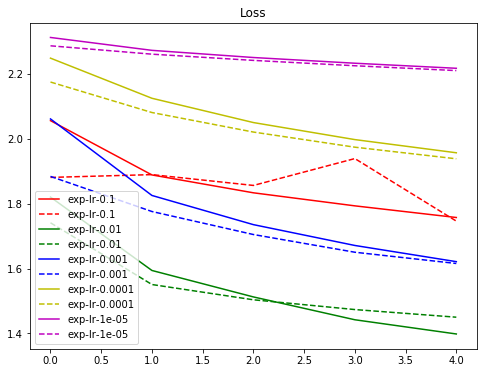

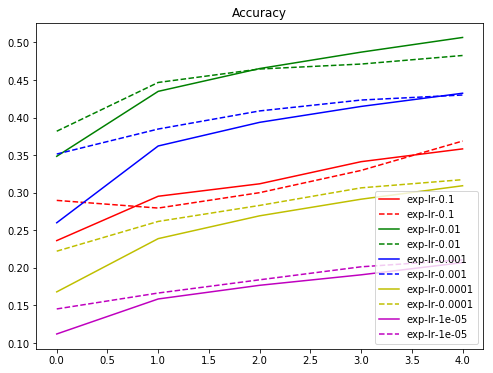

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()